In [1]:
# Install dependencies
!pip install kaggle
!pip install timm
!pip install opencv-python
!pip install brevitas
!pip install scikit-learn==1.0.2
!pip install imbalanced-learn==0.8.0

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 KB 4.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 KB 10.4 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 KB 24.8 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 44.7 MB/s eta 0:00:0000:0100:01
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━

In [2]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import brevitas.nn as qnn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
# Set seed for reproducibility
torch.manual_seed(2024)
np.random.seed(2024)

data_dir = "./data/Dataset_BUSI_with_GT"

In [3]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)  # Denoising

    # Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
    image = clahe.apply(image)
    
    # Resize & Normalize
    image = cv2.resize(image, (224, 224))
    image = image / 255.0  # Normalize
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
    
    return image

In [4]:
# Custom Dataset
class BreastUltrasoundDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = preprocess_image(self.image_paths[idx])
        label = self.labels[idx]
        return img, label

In [5]:
# Load Dataset
image_paths = []
labels = []
label_map = {"benign": 0, "malignant": 1, "normal": 2}  # Example class mapping

for class_label in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_label)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            if "mask" in image_name.lower():  # Exclude mask images
                continue
            image_paths.append(os.path.join(class_path, image_name))
            labels.append(label_map[class_label])

In [6]:
# Print dataset details
print(f"Total samples: {len(image_paths)}")
print(f"Class distribution: {Counter(labels)}")

Total samples: 780
Class distribution: Counter({0: 437, 1: 210, 2: 133})


In [7]:
unique_classes, class_counts = np.unique(labels, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls} has {count} samples.")
print(f"Dataset contains {len(set(image_paths))} unique images.")

Class 0 has 437 samples.
Class 1 has 210 samples.
Class 2 has 133 samples.
Dataset contains 780 unique images.


In [8]:
# Display before and after preprocessing
import matplotlib.pyplot as plt

def show_preprocessing_effect(sample_paths, class_label):
    fig, axes = plt.subplots(len(sample_paths), 2, figsize=(10, 5 * len(sample_paths)))
    for i, path in enumerate(sample_paths):
        original = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        processed = preprocess_image(path).squeeze().numpy()
        
        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title(f"Original - {class_label}")
        
        axes[i, 1].imshow(processed, cmap='gray')
        axes[i, 1].set_title(f"Preprocessed - {class_label}")
    plt.show()

In [9]:
# Oversampling to balance dataset
ros = RandomOverSampler(random_state=2024)
image_paths_resampled, labels_resampled = ros.fit_resample(np.array(image_paths).reshape(-1, 1), labels)
image_paths_resampled = image_paths_resampled.flatten()

In [10]:
# Splitting dataset into train, validation, and test sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths_resampled, labels_resampled, test_size=0.3, stratify=labels_resampled, random_state=2024
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=2024
)

In [11]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),  # Increased rotation range
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # Adjust contrast & brightness
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),  # Slightly increased translate
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),  # Less aggressive crop
    transforms.GaussianBlur(kernel_size=3),  # Simulate ultrasound noise
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [12]:
# Create Test Dataset and DataLoader
# Create DataLoaders
train_dataset = BreastUltrasoundDataset(train_paths, train_labels)
val_dataset = BreastUltrasoundDataset(val_paths, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = BreastUltrasoundDataset(test_paths, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 917, Validation size: 197, Test size: 197


In [13]:
class QATModel(nn.Module):
    def __init__(self, num_classes=3):
        super(QATModel, self).__init__()

        self.conv1 = qnn.QuantConv2d(1, 64, kernel_size=3, padding=1, bit_width=8)
        self.bn1 = nn.BatchNorm2d(64)  # Added BatchNorm
        self.conv2 = qnn.QuantConv2d(64, 128, kernel_size=3, padding=1, bit_width=8)
        self.bn2 = nn.BatchNorm2d(128)  # Added BatchNorm
        self.conv3 = qnn.QuantConv2d(128, 256, kernel_size=3, padding=1, bit_width=8)  # Extra conv layer
        self.bn3 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.qrelu = qnn.QuantReLU(bit_width=8)

        self.fc1_in_features = self._initialize_fc1()
        self.fc1 = qnn.QuantLinear(self.fc1_in_features, 512, bit_width=8, bias=True)
        self.fc2 = qnn.QuantLinear(512, num_classes, bit_width=8, bias=True)
        self.dropout = nn.Dropout(0.4)  # Reduced dropout to retain more information

    def _initialize_fc1(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 224, 224)
            dummy_output = self._forward_convolutions(dummy_input)
            return dummy_output.view(1, -1).size(1)

    def _forward_convolutions(self, x):
        x = self.pool(self.qrelu(self.bn1(self.conv1(x))))
        x = self.pool(self.qrelu(self.bn2(self.conv2(x))))
        x = self.pool(self.qrelu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self.pool(self.qrelu(self.bn1(self.conv1(x))))
        x = self.pool(self.qrelu(self.bn2(self.conv2(x))))
        x = self.pool(self.qrelu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.qrelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") 
model = QATModel(num_classes=3).to(device)
print(model)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)


QATModel(
  (conv1): QuantConv2d(
    1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): _

In [15]:
# Define class weights
class_weights = torch.tensor([1.0, 1.2, 1.1]).to(device)  # Adjusted based on dataset distribution
#criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-6)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_qat_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, num_classes=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    
    best_val_acc = 0.0  # Track best validation accuracy
    best_model_path = "best_model.pth"  # File to save best model

    for epoch in range(epochs):
        model.train()
        correct_train, total_train = 0, 0
        running_train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
        
        train_acc = 100 * correct_train / total_train
        train_loss = running_train_loss / len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        correct_val, total_val = 0, 0
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        
        val_acc = 100 * correct_val / total_val
        val_loss = running_val_loss / len(val_loader)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f" Best model updated and saved with Val Acc: {val_acc:.2f}%")
    
    # Plot accuracy and loss curves
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    axes[0].plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_title('Accuracy Curve')
    axes[0].legend()
    
    # Loss plot
    axes[1].plot(range(1, epochs + 1), train_losses, label='Train Loss')
    axes[1].plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Loss Curve')
    axes[1].legend()
    
    plt.show()
    
    print(f" Training complete. Best validation accuracy: {best_val_acc:.2f}%")
    
    return best_model_path  # Return the path of the best model

Epoch 1/20, Train Acc: 43.40%, Val Acc: 35.03%, Train Loss: 4.1822, Val Loss: 1.3506
 Best model updated and saved with Val Acc: 35.03%
Epoch 2/20, Train Acc: 72.74%, Val Acc: 75.63%, Train Loss: 0.8322, Val Loss: 0.6776
 Best model updated and saved with Val Acc: 75.63%
Epoch 3/20, Train Acc: 82.77%, Val Acc: 84.26%, Train Loss: 0.5876, Val Loss: 0.5419
 Best model updated and saved with Val Acc: 84.26%
Epoch 4/20, Train Acc: 92.58%, Val Acc: 89.34%, Train Loss: 0.4830, Val Loss: 0.4854
 Best model updated and saved with Val Acc: 89.34%
Epoch 5/20, Train Acc: 94.11%, Val Acc: 90.86%, Train Loss: 0.4543, Val Loss: 0.4623
 Best model updated and saved with Val Acc: 90.86%
Epoch 6/20, Train Acc: 96.18%, Val Acc: 88.32%, Train Loss: 0.4187, Val Loss: 0.4994
Epoch 7/20, Train Acc: 98.15%, Val Acc: 90.86%, Train Loss: 0.3826, Val Loss: 0.4587
Epoch 8/20, Train Acc: 98.91%, Val Acc: 89.85%, Train Loss: 0.3609, Val Loss: 0.4569
Epoch 9/20, Train Acc: 99.13%, Val Acc: 93.40%, Train Loss: 0.357

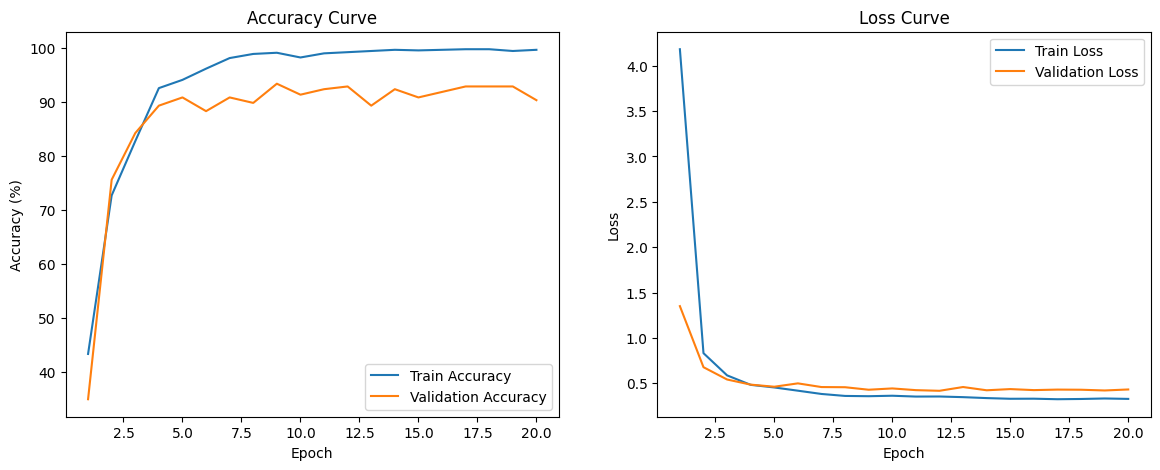

 Training complete. Best validation accuracy: 93.40%


'best_model.pth'

In [17]:
train_qat_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

In [18]:
def test_model(model, test_loader, criterion, best_model_path):
    """Loads the best model and evaluates it on the test set."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the best model before testing
    model.load_state_dict(torch.load(best_model_path))
    model.to(device)
    model.eval()
    
    correct, total = 0, 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total

    print(f"\n Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.4f}")
    return test_acc

In [20]:
 best_model_path = "best_model.pth"

In [21]:
# Training and evaluation
#best_model_path = train_qat_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)
test_accuracy = test_model(model, test_loader, criterion, best_model_path)


 Test Accuracy: 91.37%, Test Loss: 0.4754
